<a href="https://colab.research.google.com/github/gawankarsanket/dswithchirag_assignments/blob/main/Xgboost_Assignment_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook performs survival predictions of set of passesngers from titatnic dataset.
## We shall build xgboost ML model for prediction.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv("/content/titanic_train.csv") # This will use for train and test dataset
df_to_predict=pd.read_csv("/content/titanic_test.csv") # This will be  real test data

#EDA

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_to_predict.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Target variable is "Survived"  which needs to predict for df_to_predict

In [7]:
df.shape

(891, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
df.corr()

<ipython-input-10-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### In this dataset, "passenger name', cabin, ticket',fare may not have significant dependency. Hence dropping them from datast
## This is just an theory. Is there way to get statistical confirmation?


In [11]:
## Get the relavant columns only to process further

df1=df[['PassengerId', 'Survived', 'Pclass',  'Sex', 'Age', 'SibSp',
       'Parch', 'Embarked']]

df_to_predict1=df_to_predict[['PassengerId', 'Pclass',  'Sex', 'Age', 'SibSp',
       'Parch', 'Embarked']]

In [12]:
df1.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22.0,1,0,S
1,2,1,1,female,38.0,1,0,C
2,3,1,3,female,26.0,0,0,S


In [13]:
df_to_predict1.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,male,34.5,0,0,Q
1,893,3,female,47.0,1,0,S
2,894,2,male,62.0,0,0,Q


In [14]:
df1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Embarked         2
dtype: int64

In [15]:
df1.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000


In [16]:
df1[df1['Age'].isnull()].groupby('Sex').count()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Embarked
Sex,,,,,,,
female,53,53,53,0,53,53,53
male,124,124,124,0,124,124,124


### here hae 53 females , 124 males whose age is missing. Lets reaplce with mean value of age in theire respective categories, male and female

In [17]:
male_avg_age=df1[df1['Sex']=='male']['Age'].mean()
female_avg_age=df1[df1['Sex']=='female']['Age'].mean()
male_avg_age,female_avg_age

(30.72664459161148, 27.915708812260537)

In [18]:
##Rounding Off to Integer
male_avg_age=male_avg_age.round()
female_avg_age=female_avg_age.round()
male_avg_age,female_avg_age

(31.0, 28.0)

In [19]:
df1[df1['Sex']=='male']['Age']

0      22.0
4      35.0
5       NaN
6      54.0
7       2.0
       ... 
883    28.0
884    25.0
886    27.0
889    26.0
890    32.0
Name: Age, Length: 577, dtype: float64

In [20]:
df1[df1['Sex']=='male']['Age'].fillna(male_avg_age,inplace=True)

# This gives warning and doesnt really execute it. Hence trying loc method

<ipython-input-20-049ef433bfc0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[df1['Sex']=='male']['Age'].fillna(male_avg_age,inplace=True)


In [21]:
df1.loc[df1['Sex'] == 'male', 'Age'] = df1.loc[df1['Sex'] == 'male', 'Age'].fillna(male_avg_age)
df1.loc[df1['Sex'] == 'female', 'Age'] = df1.loc[df1['Sex'] == 'female', 'Age'].fillna(female_avg_age)


In [22]:
df1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       2
dtype: int64

In [23]:
#Lets fillna EMbarked point with its mode value

In [24]:
md=df1['Embarked'].mode()[0]  #To extract value at index 0
df1['Embarked'].fillna(md)


0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [25]:
## Lets check for Prediction dataset
df_to_predict1.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [26]:
# AGE has missing values. applying same logic as per df1
df_to_predict1[df_to_predict1['Age'].isnull()].groupby('Sex').count()


,PassengerId,Pclass,Age,SibSp,Parch,Embarked
Sex,,,,,,
female,25,25,0,25,25,25
male,61,61,0,61,61,61


In [27]:
male_avg_age_pr=df_to_predict1[df_to_predict1['Sex']=='male']['Age'].mean()
female_avg_age_pr=df_to_predict1[df_to_predict1['Sex']=='female']['Age'].mean()
male_avg_age_pr,female_avg_age_pr

(30.27273170731707, 30.27236220472441)

In [28]:
male_avg_age_pr=male_avg_age_pr.round()
female_avg_age_pr=female_avg_age_pr.round()
male_avg_age_pr,female_avg_age_pr

(30.0, 30.0)

In [29]:
df_to_predict1.loc[df_to_predict1['Sex'] == 'male', 'Age'] = df_to_predict1.loc[df_to_predict1['Sex'] == 'male', 'Age'].fillna(male_avg_age_pr)
df_to_predict1.loc[df_to_predict1['Sex'] == 'female', 'Age'] = df_to_predict1.loc[df_to_predict1['Sex'] == 'female', 'Age'].fillna(female_avg_age_pr)

In [30]:
df_to_predict1.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
dtype: int64

### NOW We have clean dataset

### Just take look at it once

In [44]:
df1.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,0,3,male,22.0,1,0,S
1,2,1,1,female,38.0,1,0,C
2,3,1,3,female,26.0,0,0,S


In [32]:
df_to_predict1.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,male,34.5,0,0,Q
1,893,3,female,47.0,1,0,S
2,894,2,male,62.0,0,0,Q


### Lets split into train and test

In [33]:
x=df1.drop(columns='Survived')
y=df1[['Survived']]

In [45]:
x.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,1,3,male,22.0,1,0,S
1,2,1,female,38.0,1,0,C


In [35]:
y.head(5)

,Survived
0,0
1,1
2,1
3,1
4,0


## Spliting data using train test split converts it into series and then we willnot be able apply scaling or encoding. Hence first perform encoding and then split into train test.

## label encoder, ,OHE ,standascalar etc to apply

In [46]:
x_coded=pd.get_dummies(x,columns=['Pclass','Sex','Embarked'])
df_to_predict1_coded=pd.get_dummies(df_to_predict1,columns=['Pclass','Sex','Embarked'])

x_coded.head(3)

,PassengerId,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,0,0,1,0,1,0,0,1
1,2,38.0,1,0,1,0,0,1,0,1,0,0
2,3,26.0,0,0,0,0,1,1,0,0,0,1


In [47]:
df_to_predict1_coded.head(3)



,PassengerId,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,0.452723,0,0,0,0,1,0,1,0,1,0
1,893,0.617566,1,0,0,0,1,1,0,0,0,1
2,894,0.815377,0,0,0,1,0,0,1,0,1,0


In [48]:
x_coded['Age'].unique()

array([22.  , 38.  , 26.  , 35.  , 31.  , 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 28.  , 34.  , 15.  ,  8.  ,
       19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  , 49.  ,
       29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  , 16.  ,
       25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  , 71.  ,
       37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
       55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
       20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
       10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
       24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [49]:
df_to_predict1['Age'].unique()

array([0.4527232 , 0.61756561, 0.8153765 , 0.35381775, 0.28788079,
       0.18238164, 0.39337993, 0.34063036, 0.23513121, 0.27469339,
       0.60437821, 0.30106818, 0.82856389, 0.31425557, 0.45931689,
       0.59119082, 0.72306475, 0.11644468, 0.630753  , 0.65712779,
       0.29447448, 0.53844125, 0.43294211, 0.24172491, 0.32744296,
       0.51206646, 0.78900171, 0.47250429, 0.261506  , 0.36700514,
       0.12963207, 0.22194382, 0.41975471, 0.16919425, 0.40656732,
       0.38019254, 0.37359884, 0.42634841, 0.0768825 , 0.88131346,
       0.64394039, 0.02413293, 1.        , 0.56481604, 0.20875643,
       0.01094554, 0.15600686, 0.55162864, 0.69668996, 0.34722405,
       0.52525386, 0.80218911, 0.79559541, 0.09006989, 0.19556904,
       0.70987736, 0.84175129, 0.48569168, 0.4461295 , 0.14941316,
       0.10325729, 0.00210998, 0.49887907, 0.74943954, 0.53184755,
       0.00989054, 0.24831861, 0.47909798, 0.00764869, 0.00870368,
       0.76262693, 0.        , 0.77581432, 0.18897534, 0.57800

 ## For Age column , applying minmax scaler



In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_coded['Age'] = scaler.fit_transform(x_coded[['Age']])


In [41]:
x_coded.head()

,PassengerId,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.271174,1,0,0,0,1,0,1,0,0,1
1,2,0.472229,1,0,1,0,0,1,0,1,0,0
2,3,0.321438,0,0,0,0,1,1,0,0,0,1
3,4,0.434531,1,0,1,0,0,1,0,0,0,1
4,5,0.434531,0,0,0,0,1,0,1,0,0,1


In [51]:
scaler = MinMaxScaler()
df_to_predict1['Age'] = scaler.fit_transform(df_to_predict1[['Age']])

<ipython-input-51-bb015a8bbb9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_predict1['Age'] = scaler.fit_transform(df_to_predict1[['Age']])


In [52]:
df_to_predict1_coded.head()

,PassengerId,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,0.452723,0,0,0,0,1,0,1,0,1,0
1,893,0.617566,1,0,0,0,1,1,0,0,0,1
2,894,0.815377,0,0,0,1,0,0,1,0,1,0
3,895,0.353818,0,0,0,0,1,0,1,0,0,1
4,896,0.287881,1,1,0,0,1,1,0,0,0,1


## NOW as data in encoded lets go for train test split

In [53]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_coded, y, test_size=0.2, random_state=42)

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((712, 12), (179, 12), (712, 1), (179, 1))

## We will try to build DT , RF and XGboost and see the performance

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [55]:
from sklearn.metrics import accuracy_score

def evaluate_model (model,xtrain,ytrain,xtest,ytest):
  report={}
  model.fit(xtrain, ytrain)
  preds=model.predict(xtest)
  model_score = accuracy_score(ytest,preds)
  best_parameter=model.best_params_


  return preds,model_score,best_parameter

In [56]:
from sklearn.model_selection import RandomizedSearchCV

classifier_RF=RandomForestClassifier()

## Hypeparameter Tuning for RandomForest
params_RF={'max_depth':[3,5,10,None],
        'n_estimators':[100,200,300],
        'criterion':['gini','entropy'],
        'oob_score':[True]
           }

model_RF=RandomizedSearchCV(classifier_RF,param_distributions=params_RF,scoring='accuracy',cv=3,verbose=2)

RF,RF_score,RF_best_parameter=evaluate_model(model_RF,xtrain,ytrain,xtest,ytest)

RF,RF_score*100,RF_best_parameter



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=200, oob_score=True; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=200, oob_score=True; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=200, oob_score=True; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=300, oob_score=True; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=300, oob_score=True; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=10, n_estimators=300, oob_score=True; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=100, oob_score=True; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=100, oob_score=True; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=100, oob_score=True; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=None, n_estimators=100, oob_score=True; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=None, n_estimators=100, oob_score=True; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=None, n_estimators=100, oob_score=True; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=5, n_estimators=200, oob_score=True; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=300, oob_score=True; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=300, oob_score=True; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=3, n_estimators=300, oob_score=True; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=10, n_estimators=100, oob_score=True; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=10, n_estimators=100, oob_score=True; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=10, n_estimators=100, oob_score=True; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=5, n_estimators=300, oob_score=True; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=5, n_estimators=300, oob_score=True; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=5, n_estimators=300, oob_score=True; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=None, n_estimators=200, oob_score=True; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=None, n_estimators=200, oob_score=True; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=None, n_estimators=200, oob_score=True; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


(array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1]),
 81.56424581005587,
 {'oob_score': True,
  'n_estimators': 100,
  'max_depth': 5,
  'criterion': 'entropy'})

In [57]:
from sklearn.model_selection import GridSearchCV

classifier_DT=DecisionTreeClassifier()

## Hypeparameter Tuning for DT
params_DT={'max_depth':[3,5,10,None],
           'criterion':['gini','entropy']
           }


model_DT=GridSearchCV(classifier_DT,param_grid=params_DT,scoring='accuracy',cv=5,verbose=3)

DT,DT_score,DT_best_parameter=evaluate_model(model_DT,xtrain,ytrain,xtest,ytest)

DT,DT_score*100,DT_best_parameter

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.804 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.832 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.789 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.768 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.831 total time=   0.0s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.804 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.797 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.796 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.803 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.831 total time=   0.0s
[CV 1/5] END ......criterion=gini, max_depth=10;, score=0.776 total time=   0.0s
[CV 2/5] END ......criterion=gini, max_depth=10;,

(array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0]),
 80.44692737430168,
 {'criterion': 'gini', 'max_depth': 5})

In [58]:
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

classifier_xgb=XGBClassifier()


## Hypeparameter Tuning for XGB
param_xgb= {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    #'subsample': [0.8, 1.0],
    #'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    }

model_xgb=RandomizedSearchCV(classifier_xgb,param_distributions=param_xgb,scoring='accuracy',cv=5,verbose=3)

xgb,xgb_score,xgb_best_parameter=evaluate_model(model_xgb,xtrain,ytrain,xtest,ytest)

xgb,xgb_score*100, xgb_best_parameter



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.818 total time=   0.2s
[CV 2/5] END gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.825 total time=   0.1s
[CV 3/5] END gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.824 total time=   0.1s
[CV 4/5] END gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.789 total time=   0.1s
[CV 5/5] END gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200;, score=0.817 total time=   0.1s
[CV 1/5] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=100;, score=0.811 total time=   0.1s
[CV 2/5] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=100;, score=0.804 total time=   0.1s
[CV 3/5] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=100;, score=0.810 total time=   0.2s
[CV 4/5] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=100;, score=0.775

(array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1]),
 79.88826815642457,
 {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1})

In [68]:
DT_best_parameter

{'criterion': 'gini', 'max_depth': 5}

In [69]:
RF_best_parameter

{'oob_score': True,
 'n_estimators': 100,
 'max_depth': 5,
 'criterion': 'entropy'}

In [59]:
xgb_best_parameter

{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1}

## Prediction on Test Dataset ie. df_to_predict




In [60]:
df_to_predict1_coded.head(3)

,PassengerId,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,0.452723,0,0,0,0,1,0,1,0,1,0
1,893,0.617566,1,0,0,0,1,1,0,0,0,1
2,894,0.815377,0,0,0,1,0,0,1,0,1,0


### Lets use each one of the  classifier RF , DT & XGB with their best paramter and evalute the ouput

### Prediction by DecisionTree

In [71]:
## DT
## We will pass the best parameters here.
## Note : DT_best_paramter is dict type. To unpack and use values in it , making use of **

model_DT_pred=DecisionTreeClassifier(**DT_best_parameter)
model_DT_pred.fit(xtrain, ytrain)
preds_DT=model_DT_pred.predict(df_to_predict1_coded)

preds_DT


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Prediction by RandomeForest

In [72]:
## RF
## We will pass the best parameters here.
## Note : RF_best_paramter is dict type. To unpack and use values in it , making use of **

model_RF_pred=RandomForestClassifier(**RF_best_parameter)
model_RF_pred.fit(xtrain, ytrain)
preds_RF=model_RF_pred.predict(df_to_predict1_coded)

preds_RF

<ipython-input-72-90a8c3319ef1>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RF_pred.fit(xtrain, ytrain)


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Prediction by XGBoost

In [67]:
## XGB
## We will pass the best parameters here.
## Note : xgb_best_paramter is dict type. To unpack and use values in it , making use of **

model_xgb_pred=XGBClassifier(**xgb_best_parameter)
model_xgb_pred.fit(xtrain, ytrain)
preds_xgb=model_xgb_pred.predict(df_to_predict1_coded)

preds_xgb


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## PREDCITED TEST DATASET

In [73]:

df_to_predict['Survival Prediction_DT']=preds_DT
df_to_predict['Survival Prediction_RF']=preds_RF
df_to_predict['Survival Prediction_XGB']=preds_xgb


df_to_predict.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survival Prediction_DT,Survival Prediction_RF,Survival Prediction_XGB
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,0,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1,1,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,0,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,1,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,0,0


## Visualition to see survival predicted count by each model


In [75]:
df_to_predict['Survival Prediction_DT'].value_counts()

0    292
1    126
Name: Survival Prediction_DT, dtype: int64

In [76]:
df_to_predict['Survival Prediction_RF'].value_counts()

0    290
1    128
Name: Survival Prediction_RF, dtype: int64

In [77]:
df_to_predict['Survival Prediction_XGB'].value_counts()

0    294
1    124
Name: Survival Prediction_XGB, dtype: int64

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

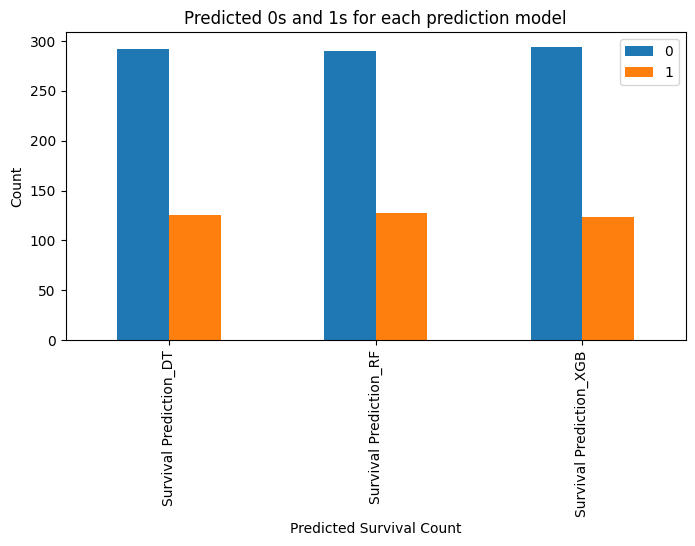

In [83]:
## PLOTTING

count_df = df_to_predict[['Survival Prediction_DT','Survival Prediction_RF','Survival Prediction_XGB']].apply(lambda x: x.value_counts()).T

# bar plot
ax = count_df.plot(kind='bar', stacked=False, figsize=(8, 4))
plt.xlabel('Predicted Survival Count')
plt.ylabel('Count')
plt.title('Predicted 0s and 1s for each prediction model')
plt.legend()
plt.plot